In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import Formula
from rpy2.robjects.vectors import FloatVector, IntVector, ListVector, Vector, StrVector
from rpy2.robjects import DataFrame, IntVector

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")
graphics = importr("graphics")
stats = importr("stats")
lmtest = importr("lmtest")

In [2]:
dfs = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/combined_other_datasets_for_modeling.csv')
dfs1 = dfs.copy()

print(dfs1.shape)
print()
print(dfs1.info())
print()
dfs1.head(3)


(1678, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   float64
 2   Vital_capacity    1678 non-null   float64
 3   Sex               1678 non-null   object 
 4   Onset_site        1678 non-null   object 
 5   Study_Arm         1678 non-null   object 
 6   European          1678 non-null   int64  
 7   Age               1678 non-null   float64
 8   Diagnostic_Delay  1678 non-null   float64
 9   Disease_Duration  1678 non-null   float64
 10  TRICALS           1678 non-null   float64
 11  Study_id          1678 non-null   object 
 12  Expt              1678 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 170.6+ KB
None



,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals


In [3]:
from going_modular import *

In [4]:
# check_value_counts for categorical and object columns
check_value_counts(dfs1.drop(columns=['subject_id']))

Sex: {'1': 748, '0': 534, 'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Onset_site: {'1.0': 1151, 'Limb': 318, '0.0': 82, 'Bulbar': 77, '2.0': 49, 'Other': 1}

Study_Arm: {'ACTIVE': 876, 'PLACEBO': 406, 'Placebo': 197, 'IL2': 110, 'Active': 89}

Study_id: {'301': 959, 'miro': 220, 'lica': 176, '302': 168, '216': 155}

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}



In [5]:
print(f"Data shape before exclusion: {dfs1.shape} \n")
dfs1 = dfs1[dfs1['Expt'] != 'riluzole']

print(f"Data shape after exclusion: {dfs1.shape}")

Data shape before exclusion: (1678, 13) 

Data shape after exclusion: (396, 13)


In [6]:
df_time_var = dfs1[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
df_time_var.describe()
# df_time_var.isna().sum()

,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,396.000000,396.000000,396.000000
mean,29.773236,12.600114,93.606061
std,8.569203,5.929346,17.016042
min,8.051348,0.984000,60.000000
25%,24.530716,7.923000,80.000000
50%,31.473046,12.481527,92.000000
75%,36.177070,16.962729,104.000000
max,50.636005,31.767411,139.000000


In [7]:
# Log-transform specified columns
dfs1 = log_transform_columns(dfs1, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
dfs1.head()

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,3.514542,2.681058,4.682131
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,3.750416,3.051071,4.605170
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,3.571548,2.807691,4.634729
3,P01004,0.0,99.0,Male,Limb,Active,1,47.192334,9.428384,28.428384,-5.956706,lica,licals,3.381960,2.344531,4.605170
4,P01005,0.0,108.0,Male,Bulbar,Placebo,1,71.307324,19.726347,38.726347,-5.058994,lica,licals,3.682015,3.031406,4.691348


In [8]:
# Make some columns categorical
dfs1 = make_columns_object(dfs1, ['European', 'Event'])
dfs1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          396 non-null    object 
 1   Event               396 non-null    object 
 2   Vital_capacity      396 non-null    float64
 3   Sex                 396 non-null    object 
 4   Onset_site          396 non-null    object 
 5   Study_Arm           396 non-null    object 
 6   European            396 non-null    object 
 7   Age                 396 non-null    float64
 8   Diagnostic_Delay    396 non-null    float64
 9   Disease_Duration    396 non-null    float64
 10  TRICALS             396 non-null    float64
 11  Study_id            396 non-null    object 
 12  Expt                396 non-null    object 
 13  Disease_Duration_l  396 non-null    float64
 14  Diagnostic_Delay_l  396 non-null    float64
 15  Vital_capacity_l    396 non-null    float64
dtypes: float64(8)

In [9]:
# standardize columns
dfs1 = standardize_column(dfs1)
dfs1.head()

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,3.571548,2.807691,4.634729,0.493296,-1.123785,0.501152,0.559956,-1.189109,0.586210,0.616453,0.563821
3,P01004,0.0,99.0,Male,Limb,Active,1,47.192334,9.428384,28.428384,-5.956706,lica,licals,3.381960,2.344531,4.605170,0.316991,-1.077042,-0.534921,-0.156940,-0.869383,0.008949,-0.309577,0.398812
4,P01005,0.0,108.0,Male,Bulbar,Placebo,1,71.307324,19.726347,38.726347,-5.058994,lica,licals,3.682015,3.031406,4.691348,0.845904,1.223044,1.201858,1.044801,-0.181323,0.922560,1.063742,0.879892


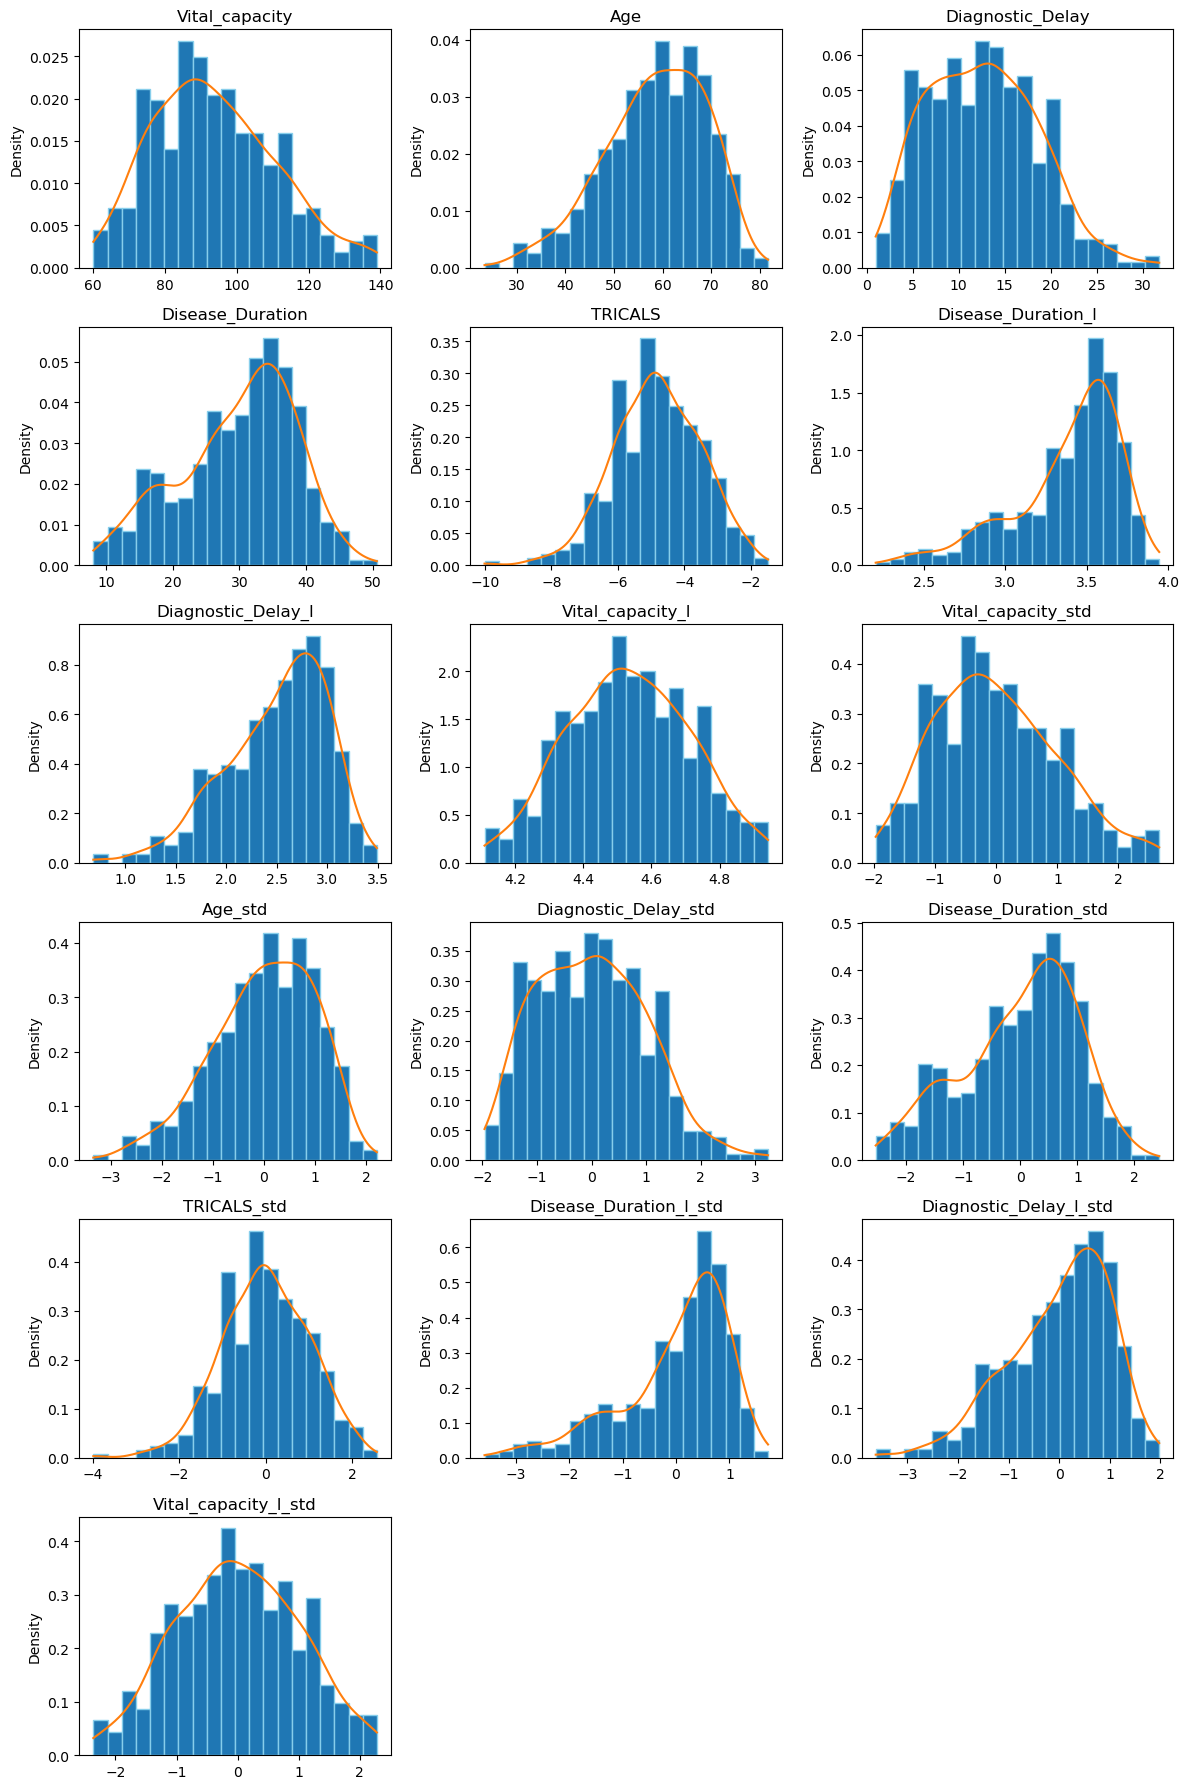

In [10]:
# plot histograms with density
plot_histograms_with_kde(dfs1.drop(columns=['subject_id']))

In [11]:
dfs1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subject_id              396 non-null    object 
 1   Event                   396 non-null    object 
 2   Vital_capacity          396 non-null    float64
 3   Sex                     396 non-null    object 
 4   Onset_site              396 non-null    object 
 5   Study_Arm               396 non-null    object 
 6   European                396 non-null    object 
 7   Age                     396 non-null    float64
 8   Diagnostic_Delay        396 non-null    float64
 9   Disease_Duration        396 non-null    float64
 10  TRICALS                 396 non-null    float64
 11  Study_id                396 non-null    object 
 12  Expt                    396 non-null    object 
 13  Disease_Duration_l      396 non-null    float64
 14  Diagnostic_Delay_l      396 non-null    float64

In [12]:
check_value_counts(dfs1.drop(columns=['subject_id']))

Event: {0.0: 240, 1.0: 156}

Sex: {'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Onset_site: {'Limb': 318, 'Bulbar': 77, 'Other': 1}

Study_Arm: {'Placebo': 197, 'IL2': 110, 'Active': 89}

European: {1: 392, 0: 4}

Study_id: {'miro': 220, 'lica': 176}

Expt: {'mirocals': 220, 'licals': 176}



In [13]:
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar', 'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

dfs1['Onset_site'] = dfs1['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

dfs1['Sex'] = dfs1['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

dfs1['Study_Arm'] = dfs1['Study_Arm'].map(mapping2)

#________
dfs1['European'] = np.where(dfs1['European'] == 0, 'Non-European', 'European')

In [14]:
check_value_counts(dfs1.drop(columns=['subject_id']))

Event: {0.0: 240, 1.0: 156}

Sex: {'Male': 262, 'Female': 134}

Onset_site: {'Limb': 319, 'Bulbar': 77}

Study_Arm: {'Active': 199, 'Placebo': 197}

European: {'European': 392, 'Non-European': 4}

Study_id: {'miro': 220, 'lica': 176}

Expt: {'mirocals': 220, 'licals': 176}



In [15]:
dfs1.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std
0,P01001,0.0,107.0,Male,Limb,Placebo,European,54.762491,13.600526,32.600526,-4.921357,lica,licals,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441
1,P01002,1.0,99.0,Female,Limb,Placebo,European,61.160849,20.137976,41.538765,-6.347018,lica,licals,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812
2,P01003,0.0,102.0,Male,Limb,Active,European,46.702259,15.571616,34.571616,-6.373852,lica,licals,3.571548,2.807691,4.634729,0.493296,-1.123785,0.501152,0.559956,-1.189109,0.586210,0.616453,0.563821


In [16]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex', 'Study_Arm','Expt']

# One-hot encode
df_onehot = pd.get_dummies(dfs1, columns=cat_cols, drop_first=True)

df_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441,True,False,True,True,False
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,lica,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812,True,False,False,True,False


In [17]:
df_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Disease_Duration_l',
       'Diagnostic_Delay_l', 'Vital_capacity_l', 'Vital_capacity_std',
       'Age_std', 'Diagnostic_Delay_std', 'Disease_Duration_std',
       'TRICALS_std', 'Disease_Duration_l_std', 'Diagnostic_Delay_l_std',
       'Vital_capacity_l_std', 'Onset_site_Limb', 'European_Non-European',
       'Sex_Male', 'Study_Arm_Placebo', 'Expt_mirocals'],
      dtype='object')

In [18]:
cols = ['Onset_site_Limb', 'Sex_Male', 'Study_Arm_Placebo', 'Expt_mirocals']

# Convert one-hot encoded columns to int
for col in cols:
    df_onehot[col] = df_onehot[col].astype(int)

df_onehot.head(3)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441,1,False,1,1,0
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,lica,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812,1,False,0,1,0
2,P01003,0.0,102.0,46.702259,15.571616,34.571616,-6.373852,lica,3.571548,2.807691,4.634729,0.493296,-1.123785,0.501152,0.559956,-1.189109,0.586210,0.616453,0.563821,1,False,1,0,0


In [19]:
# Create interactions
df_onehot['Sex_onset'] = df_onehot['Sex_Male']*df_onehot['Onset_site_Limb']
df_onehot['Age_Sex'] = df_onehot['Sex_Male']*df_onehot['Age_std']
df_onehot['Age_onset'] = df_onehot['Age_std']*df_onehot['Onset_site_Limb']
df_onehot['Age_TRICALS'] = df_onehot['Age_std']*df_onehot['TRICALS_std']
# df_onehot['Trical : Placebo Arm'] = df_onehot['TRICALS']*df_onehot['Study_Arm_Placebo']

# df_onehot.info()
df_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441,1,False,1,1,0,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,lica,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812,1,False,0,1,0,0,0.000000,0.255274,-0.298299


In [20]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subject_id              396 non-null    object 
 1   Event                   396 non-null    object 
 2   Vital_capacity          396 non-null    float64
 3   Age                     396 non-null    float64
 4   Diagnostic_Delay        396 non-null    float64
 5   Disease_Duration        396 non-null    float64
 6   TRICALS                 396 non-null    float64
 7   Study_id                396 non-null    object 
 8   Disease_Duration_l      396 non-null    float64
 9   Diagnostic_Delay_l      396 non-null    float64
 10  Vital_capacity_l        396 non-null    float64
 11  Vital_capacity_std      396 non-null    float64
 12  Age_std                 396 non-null    float64
 13  Diagnostic_Delay_std    396 non-null    float64
 14  Disease_Duration_std    396 non-null    float64

In [21]:
df1 = df_onehot.copy()

In [22]:
df1.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Disease_Duration_l',
       'Diagnostic_Delay_l', 'Vital_capacity_l', 'Vital_capacity_std',
       'Age_std', 'Diagnostic_Delay_std', 'Disease_Duration_std',
       'TRICALS_std', 'Disease_Duration_l_std', 'Diagnostic_Delay_l_std',
       'Vital_capacity_l_std', 'Onset_site_Limb', 'European_Non-European',
       'Sex_Male', 'Study_Arm_Placebo', 'Expt_mirocals', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [23]:
df1 = df1[['subject_id', 'Event', 'Disease_Duration', 'Expt_mirocals', 'Study_id', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
        'Sex_Male',
       'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

df1 = df1.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

df1.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Expt_mirocals', 'Study_id',
       'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset', 'Age_Sex',
       'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [24]:
df1.head(3)

,subject_id,Event,Disease_Duration,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,32.600526,0,lica,1,-0.355001,-0.075830,0.363265,0.828441,1,1,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,41.538765,0,lica,1,0.255274,-1.168542,1.103061,0.398812,1,0,0,0.000000,0.255274,-0.298299
2,P01003,0.0,34.571616,0,lica,0,-1.123785,-1.189109,0.616453,0.563821,1,1,1,-1.123785,-1.123785,1.336303


In [25]:
# df1.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/processed_data_for_flexible_parametric_model.csv', index=False)

In [26]:
# Train / Test split
print(df1.shape)

# Separate features from survival info
X = df1.drop(columns=['Disease_Duration', 'Event'])
y_duration = df1['Disease_Duration']
y_event = df1['Event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.20, random_state=4
)

# Combine back for lifelines format
train_df = X_train.copy()
train_df['Disease_Duration'] = y_duration_train
train_df['Event'] = y_event_train

test_df = X_test.copy()
test_df['Disease_Duration'] = y_duration_test
test_df['Event'] = y_event_test

len(train_df), len(test_df)

(396, 16)


(316, 80)

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 239 to 122
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         316 non-null    object 
 1   Expt_mirocals      316 non-null    int64  
 2   Study_id           316 non-null    object 
 3   Study_Arm_Placebo  316 non-null    int64  
 4   Age                316 non-null    float64
 5   TRICALS            316 non-null    float64
 6   Diagnostic_Delay   316 non-null    float64
 7   Vital_capacity     316 non-null    float64
 8   Onset_Limb         316 non-null    int64  
 9   Sex_Male           316 non-null    int64  
 10  Sex_onset          316 non-null    int64  
 11  Age_Sex            316 non-null    float64
 12  Age_onset          316 non-null    float64
 13  Age_TRICALS        316 non-null    float64
 14  Disease_Duration   316 non-null    float64
 15  Event              316 non-null    object 
dtypes: float64(8), int64(5), obje

In [28]:
train_df = make_columns_int(train_df, ["Event"])
test_df = make_columns_int(test_df, ["Event"])

/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/going_modular/make_columns_int.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0).astype(int)
/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/going_modular/make_columns_int.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(0).astype(int)


In [29]:
with conversion.localconverter(pandas2ri.converter):
    r_df_train = pandas2ri.py2rpy(train_df)

with conversion.localconverter(pandas2ri.converter):
    r_df_test = pandas2ri.py2rpy(test_df)

# with conversion.localconverter(pandas2ri.converter):
#     r_df = pandas2ri.py2rpy(df1)

#### CV Backward stepwise selection based on AIC and spline df selection
<!-- ##### investigate the code further -->

In [30]:
# Candidate covariates (modify for your dataset)
covariates = [
   'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS','Expt_mirocals'
    ]

df_candidates = [0,1, 2, 3]#, 4, 5, 6, 7, 8, 9, 10, 11]

In [31]:
# import inspect
# inspect.signature(perform_fp_model_cv_aic_for_model)


In [32]:
# Perform flexible parametric model cross-validation with AIC
model_0 = perform_fp_model_cv_aic_for_model(train_df=train_df, covariates=covariates, df_candidates=df_candidates, n_splits=2)
model_0


Selected model by CV-AIC:
Variables: ['Age', 'TRICALS', 'Diagnostic_Delay', 'Onset_Limb', 'Sex_Male', 'Sex_onset']
Spline df: 0
CV-AIC: 467.628906215867


### *Fit a flexible parametric survival model (baseline model) -  The baseline log-cumulative-hazard* 

In [33]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb  + Sex_onset + Expt_mirocals + Diagnostic_Delay + Study_Arm_Placebo')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df_train, df=0)
# print(ro.r.summary(fp_model))

In [34]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb + TRICALS + Sex_onset + Expt_mirocals + Diagnostic_Delay + Study_Arm_Placebo')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df_train, df=0)
# print(ro.r.summary(fp_model))

In [35]:
df_coef = extract_coefficients_from_fp_model_log_haz_scale(fp_model)
df_coef

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),LHR,CI_lower,CI_upper,Significant
0,Age,-0.448234,0.124308,-3.605831,3.111551e-04,-0.448234,-0.691878,-0.204590,True
1,Sex_Male,0.763143,0.387092,1.971478,4.866922e-02,0.763143,0.004443,1.521843,True
2,Onset_Limb,0.934429,0.317947,2.938940,3.293365e-03,0.934429,0.311252,1.557606,True
3,TRICALS,3.188054,0.231746,13.756661,4.644879e-43,3.188054,2.733832,3.642277,True
4,Sex_onset,-1.135581,0.437486,-2.595697,9.439938e-03,-1.135581,-1.993053,-0.278108,True
5,Expt_mirocals,-0.309485,0.230798,-1.340939,1.799401e-01,-0.309485,-0.761849,0.142878,False
6,Diagnostic_Delay,0.161300,0.133848,1.205094,2.281672e-01,0.161300,-0.101043,0.423643,False
7,Study_Arm_Placebo,0.184740,0.181350,1.018692,3.083492e-01,0.184740,-0.170706,0.540186,False


In [ ]:
df_coef = extract_coefficients_from_fp_model_haz_scale(fp_model)
df_coef

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.448234,0.124308,-3.605831,3.111551e-04,0.638755,0.500635,0.814981,True
1,Sex_Male,0.763143,0.387092,1.971478,4.866922e-02,2.145008,1.004453,4.580660,True
2,Onset_Limb,0.934429,0.317947,2.938940,3.293365e-03,2.545758,1.365133,4.747440,True
3,TRICALS,3.188054,0.231746,13.756661,4.644879e-43,24.241216,15.391751,38.178667,True
4,Sex_onset,-1.135581,0.437486,-2.595697,9.439938e-03,0.321235,0.136279,0.757215,True
5,Expt_mirocals,-0.309485,0.230798,-1.340939,1.799401e-01,0.733824,0.466803,1.153589,False
6,Diagnostic_Delay,0.161300,0.133848,1.205094,2.281672e-01,1.175037,0.903894,1.527516,False
7,Study_Arm_Placebo,0.184740,0.181350,1.018692,3.083492e-01,1.202905,0.843069,1.716326,False


Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



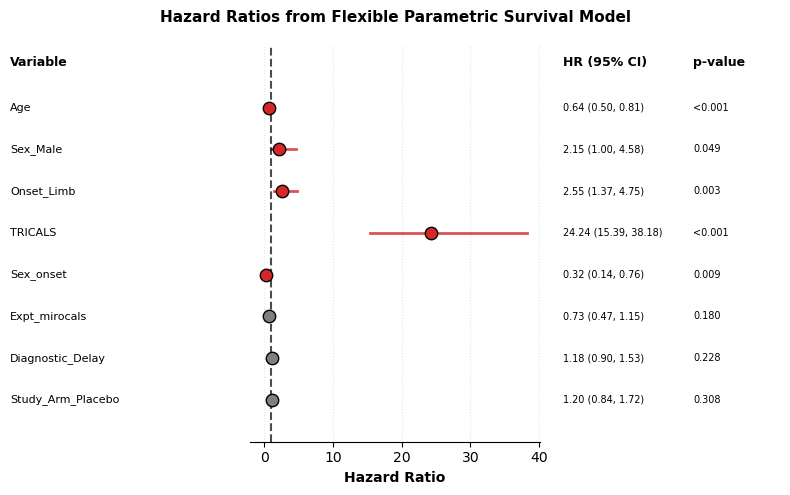

In [37]:
forest_plot_fp_model_haz_scale(extract_coefficients_from_fp_model_haz_scale(fp_model))

In [38]:
# train_df.columns = train_df.columns.str.replace(' ', '_')
# test_df.columns = test_df.columns.str.replace(' ', '_')
train_df.columns

Index(['subject_id', 'Expt_mirocals', 'Study_id', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS',
       'Disease_Duration', 'Event'],
      dtype='object')

In [39]:
means = ["Age", "TRICALS", "Diagnostic_Delay"]
modes = ["Sex_Male", "Onset_Limb", "Study_Arm_Placebo", "Expt_mirocals", "Sex_onset"]

In [40]:
# from going_modular import *

In [41]:
# import inspect
# inspect.signature(make_newdata_for_fp_model_prediction)

In [42]:
# Prepare newdata for train and test
newdata_train = make_newdata_for_fp_model_prediction(train_df, means, modes, 'Disease_Duration')
newdata_test = make_newdata_for_fp_model_prediction(test_df, means, modes, 'Disease_Duration')

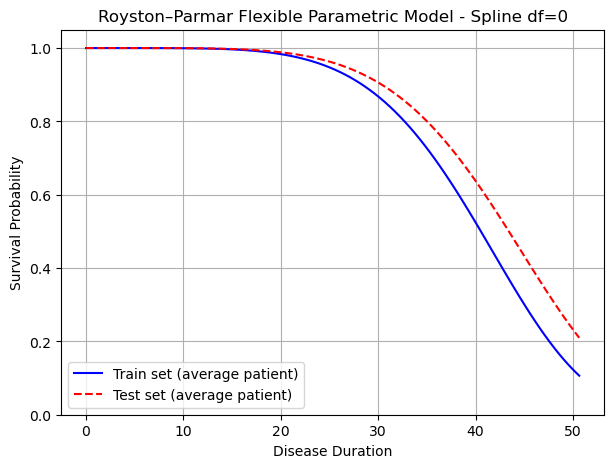

In [43]:
prediction_survival_for_average_patient_fp_model_train_test(df1, fp_model, newdata_train, newdata_test, 'Disease_Duration')

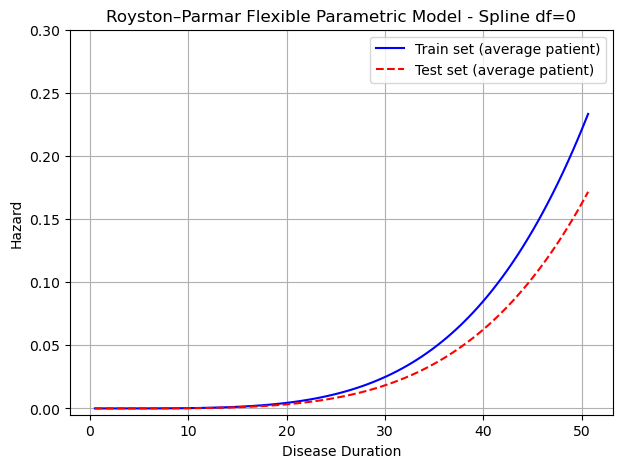

In [44]:
prediction_hazard_for_average_patient_fp_model_train_test(df1, fp_model, newdata_train=newdata_train, newdata_test=newdata_test, time_col='Disease_Duration')

In [45]:
newdata_0_train, newdata_1_train = make_newdata_category_for_fp_model_prediction(train_df, means, modes, time_col="Disease_Duration", cat_col='Expt_mirocals')
newdata_0_test, newdata_1_test = make_newdata_category_for_fp_model_prediction(test_df, means, modes, time_col="Disease_Duration", cat_col='Expt_mirocals')

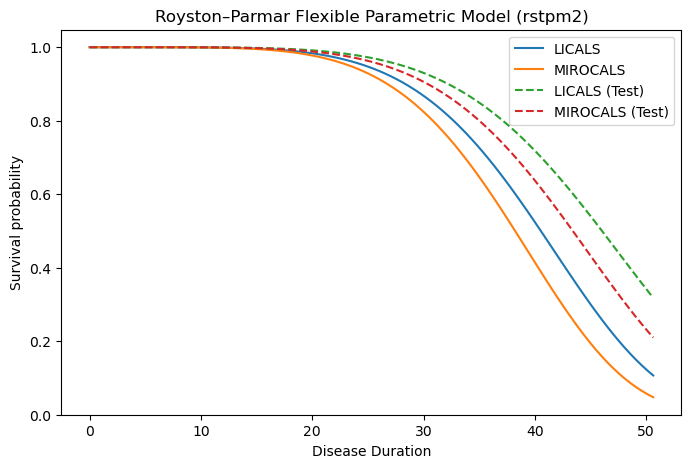

In [46]:
prediction_survival_for_average_patient_cat_cov_fp_model_train_test(df1,
                                                                    fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    time_col='Disease_Duration',
                                                                    cat_col_0='LICALS',
                                                                    cat_col_1='MIROCALS')

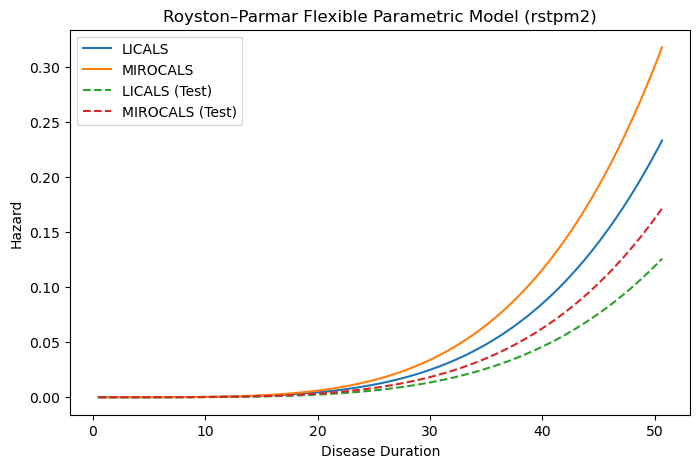

In [47]:
prediction_hazard_for_average_patient_cat_cov_fp_model_train_test(df1,
                                                                    fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    time_col='Disease_Duration',
                                                                    cat_col_0='LICALS',
                                                                    cat_col_1='MIROCALS')

In [48]:
newdata_0_train, newdata_1_train = make_newdata_category_for_fp_model_prediction(train_df, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')
newdata_0_test, newdata_1_test = make_newdata_category_for_fp_model_prediction(test_df, means, modes, time_col="Disease_Duration", cat_col='Study_Arm_Placebo')

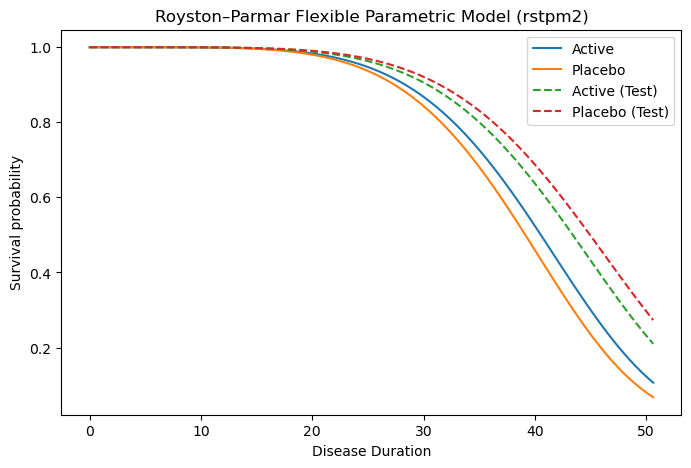

In [49]:
prediction_survival_for_average_patient_cat_cov_fp_model_train_test(dfs1,
                                                                    fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    time_col='Disease_Duration',
                                                                    cat_col_0='Active',
                                                                    cat_col_1='Placebo')

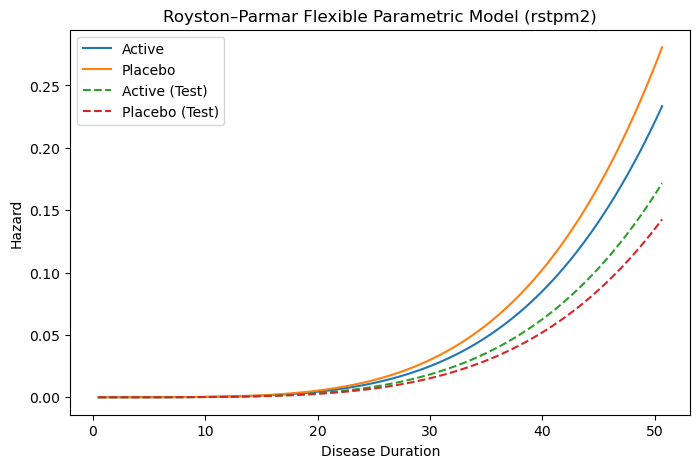

In [50]:
prediction_hazard_for_average_patient_cat_cov_fp_model_train_test(df1,
                                                                    fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    time_col='Disease_Duration',
                                                                    cat_col_0='Active',
                                                                    cat_col_1='Placebo')

In [51]:
# Perform likelihood ratio test between two models



## Prognostic Scores for Baseline Model (fit)

In [52]:
# %%writefile going_modular/prognostic_score.py
def prognostic_score(df, fp_model, groups):
    # prognostic score (linear predictor) with standard error
    r_predict = r['predict']

    df["prognostic_score"] = r_predict(fp_model, type = "link")

    if groups == 2:
        df['risk_group'] = pd.qcut(df['prognostic_score'], groups, labels=['Low','High'])
    elif groups == 3:
        df['risk_group'] = pd.qcut(df['prognostic_score'], groups, labels=['Low','Medium','High'])

    return df


In [53]:
train_df = prognostic_score(train_df, fp_model, groups=3)
train_df

,subject_id,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Disease_Duration,Event,prognostic_score,risk_group
239,1-63540,1,miro,0,0.281614,2.027815,-1.158655,-0.777522,1,1,1,0.281614,0.281614,0.571060,10.080894,1,-1.669714,Medium
337,1-62576,1,miro,0,-1.532990,-1.593412,-0.514605,-0.508438,1,1,1,-1.532990,-1.532990,2.442684,31.308967,0,-6.320542,Low
18,P01022,0,lica,1,-1.734582,-0.692921,-0.536083,-0.251729,1,0,0,-0.000000,-1.734582,1.201929,27.311432,0,-3.216565,Low
248,1-63498,1,miro,1,0.141405,0.311216,-0.427318,-0.917090,1,1,1,0.141405,0.141405,0.044008,33.468967,0,-0.448348,High
134,P08001,0,lica,0,-0.288411,-0.667240,1.078864,0.981393,1,1,1,-0.288411,-0.288411,0.192439,38.883706,0,-2.216531,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1-62643,1,miro,1,0.400743,1.337852,-0.571487,0.617758,0,0,0,0.000000,0.000000,0.536135,19.778859,1,-0.650906,High
385,1-63448,1,miro,0,-1.118278,-0.206703,-0.095318,0.776511,1,0,0,-0.000000,-1.118278,0.231151,33.480967,0,-1.291730,Medium
197,1-62258,1,miro,0,1.130113,0.386851,-0.334344,-0.574503,1,1,1,1.130113,1.130113,0.437186,33.708967,0,-0.782455,High
174,P10020,0,lica,0,1.368236,0.885243,0.794566,-1.435037,1,0,0,0.000000,1.368236,1.211221,25.441524,1,0.079781,High


In [54]:
train_df['risk_group'] = pd.qcut(train_df['prognostic_score'], 3, labels=['Low','Medium','High'])

train_df.head(6)
train_df.risk_group.value_counts().to_dict()

{'Low': 106, 'High': 106, 'Medium': 104}

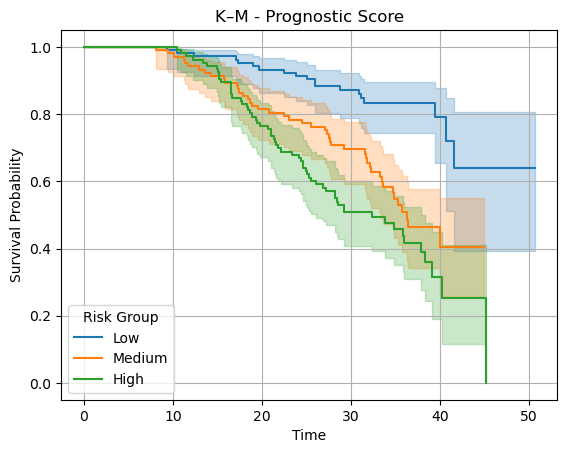

In [55]:
for group in ['Low','Medium','High']:
    subset = train_df[train_df['risk_group']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

## ***Simulate Virtual Placebo***

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 239 to 122
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   subject_id         316 non-null    object  
 1   Expt_mirocals      316 non-null    int64   
 2   Study_id           316 non-null    object  
 3   Study_Arm_Placebo  316 non-null    int64   
 4   Age                316 non-null    float64 
 5   TRICALS            316 non-null    float64 
 6   Diagnostic_Delay   316 non-null    float64 
 7   Vital_capacity     316 non-null    float64 
 8   Onset_Limb         316 non-null    int64   
 9   Sex_Male           316 non-null    int64   
 10  Sex_onset          316 non-null    int64   
 11  Age_Sex            316 non-null    float64 
 12  Age_onset          316 non-null    float64 
 13  Age_TRICALS        316 non-null    float64 
 14  Disease_Duration   316 non-null    float64 
 15  Event              316 non-null    int64   
 16  prognostic_

In [57]:
cols = ['subject_id']

for col in (train_df.select_dtypes(include=['object', 'category', 'int']).columns):
    if col not in cols:
        print(f"{train_df[col].value_counts() / train_df[col].value_counts().sum()}\n")

Expt_mirocals
1    0.575949
0    0.424051
Name: count, dtype: float64

Study_id
miro    0.575949
lica    0.424051
Name: count, dtype: float64

Study_Arm_Placebo
0    0.506329
1    0.493671
Name: count, dtype: float64

Onset_Limb
1    0.813291
0    0.186709
Name: count, dtype: float64

Sex_Male
1    0.648734
0    0.351266
Name: count, dtype: float64

Sex_onset
1    0.556962
0    0.443038
Name: count, dtype: float64

Event
0    0.60443
1    0.39557
Name: count, dtype: float64

risk_group
Low       0.335443
High      0.335443
Medium    0.329114
Name: count, dtype: float64



In [58]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
pla = train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()
exp = train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()
# eur = train_df['European_Yes'].value_counts() / train_df['European_Yes'].value_counts().sum()


In [59]:
ons, sex

(Onset_Limb
 1    0.813291
 0    0.186709
 Name: count, dtype: float64,
 Sex_Male
 1    0.648734
 0    0.351266
 Name: count, dtype: float64)

In [60]:
df1.head(3)

,subject_id,Event,Disease_Duration,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,32.600526,0,lica,1,-0.355001,-0.075830,0.363265,0.828441,1,1,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,41.538765,0,lica,1,0.255274,-1.168542,1.103061,0.398812,1,0,0,0.000000,0.255274,-0.298299
2,P01003,0.0,34.571616,0,lica,0,-1.123785,-1.189109,0.616453,0.563821,1,1,1,-1.123785,-1.123785,1.336303


In [61]:
df1.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Expt_mirocals', 'Study_id',
       'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset', 'Age_Sex',
       'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [62]:
df1.head(3)

,subject_id,Event,Disease_Duration,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,32.600526,0,lica,1,-0.355001,-0.075830,0.363265,0.828441,1,1,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,41.538765,0,lica,1,0.255274,-1.168542,1.103061,0.398812,1,0,0,0.000000,0.255274,-0.298299
2,P01003,0.0,34.571616,0,lica,0,-1.123785,-1.189109,0.616453,0.563821,1,1,1,-1.123785,-1.123785,1.336303


In [63]:
corr = train_df[['Age', 'Expt_mirocals','Study_Arm_Placebo','Diagnostic_Delay','Vital_capacity','Sex_Male', 
            	 'Onset_Limb','TRICALS']].corr()
corr

,Age,Expt_mirocals,Study_Arm_Placebo,Diagnostic_Delay,Vital_capacity,Sex_Male,Onset_Limb,TRICALS
Age,1.000000,-0.010130,0.052182,0.092308,0.061956,-0.109871,-0.039644,0.372228
Expt_mirocals,-0.010130,1.000000,0.014753,-0.532990,0.138802,-0.121661,-0.049610,0.139629
Study_Arm_Placebo,0.052182,0.014753,1.000000,0.083810,0.049934,-0.042464,0.034543,-0.047414
Diagnostic_Delay,0.092308,-0.532990,0.083810,1.000000,-0.005506,0.007442,-0.015371,-0.445967
Vital_capacity,0.061956,0.138802,0.049934,-0.005506,1.000000,-0.156256,0.107623,-0.223723
Sex_Male,-0.109871,-0.121661,-0.042464,0.007442,-0.156256,1.000000,0.157792,-0.106294
Onset_Limb,-0.039644,-0.049610,0.034543,-0.015371,0.107623,0.157792,1.000000,-0.169764
TRICALS,0.372228,0.139629,-0.047414,-0.445967,-0.223723,-0.106294,-0.169764,1.000000


In [64]:
df = df_coef.copy()
df

,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.448234,0.124308,-3.605831,3.111551e-04,0.638755,0.500635,0.814981,True
1,Sex_Male,0.763143,0.387092,1.971478,4.866922e-02,2.145008,1.004453,4.580660,True
2,Onset_Limb,0.934429,0.317947,2.938940,3.293365e-03,2.545758,1.365133,4.747440,True
3,TRICALS,3.188054,0.231746,13.756661,4.644879e-43,24.241216,15.391751,38.178667,True
4,Sex_onset,-1.135581,0.437486,-2.595697,9.439938e-03,0.321235,0.136279,0.757215,True
5,Expt_mirocals,-0.309485,0.230798,-1.340939,1.799401e-01,0.733824,0.466803,1.153589,False
6,Diagnostic_Delay,0.161300,0.133848,1.205094,2.281672e-01,1.175037,0.903894,1.527516,False
7,Study_Arm_Placebo,0.184740,0.181350,1.018692,3.083492e-01,1.202905,0.843069,1.716326,False


In [65]:
# df.loc[df["Variable"] == "Age", "Estimate"].values[0]
# ons
# sex[1]
# pla[1]

In [66]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "Age", "Estimate"].values[0]},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "TRICALS", "Estimate"].values[0]},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Diagnostic_Delay", "Estimate"].values[0]},
    # {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
    #                                                        'coef':df.loc[df["Variable"] == "Vital capacity", "Estimate"].values[0]},

    # binary
    {'name':'Sex_Male','type':'binary','prob':sex[1],'coef':df.loc[df["Variable"] == "Sex_Male", "Estimate"].values[0]},
    {'name':'Onset_Limb','type':'binary','prob':ons[1],'coef':df.loc[df["Variable"] == "Onset_Limb", "Estimate"].values[0]},
    {'name':'Expt_mirocals','type':'binary','prob':exp[1],'coef':df.loc[df["Variable"] == "Expt_mirocals", "Estimate"].values[0]},
    {'name':'Study_Arm_Placebo','type':'binary','prob':pla[1],'coef':df.loc[df["Variable"] == "Study_Arm_Placebo", "Estimate"].values[0]},

    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
]

corr = train_df[['Age', 'TRICALS', 'Diagnostic_Delay','Sex_Male', 'Onset_Limb', 'Expt_mirocals', 'Study_Arm_Placebo']].corr()

# df_sim = simulate_cox_dataset(n=df1.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
#                               censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


# df_sim.head(3)

In [67]:
train_df.Event.value_counts() / train_df.Event.value_counts().sum()

Event
0    0.60443
1    0.39557
Name: count, dtype: float64

In [68]:
H0_df = estimate_baseline_cumhaz(train_df, time_col='Disease_Duration', event_col='Event')
# H0_df

In [69]:
# Real dataset
# H0_df = estimate_baseline_cumhaz(real_df)

# Simulated dataset
sim_df = simulate_cox_dataset_with_correlation(
    # n=500,
    n=train_df.shape[0],
    var_specs=var_specs_real,
    corr=corr,
    baseline="empirical",
    H0_df=H0_df,
    censor_rate=0.4,
    seed=42
)


In [70]:
sim_df.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex_Male,Onset_Limb,Expt_mirocals,Study_Arm_Placebo
0,1.033106,1,1.033106,6.447372,1.017988,1.998377,-1.428441,1,0,0,0
1,10.636228,0,16.627864,2.104530,-0.371738,0.100564,0.275729,1,1,1,1
2,0.563632,1,0.563632,6.534046,-0.679490,1.706508,-0.984806,1,0,0,1


In [71]:
# Create interactions
sim_df['Sex_onset'] = sim_df['Sex_Male']*sim_df['Onset_Limb']
sim_df.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex_Male,Onset_Limb,Expt_mirocals,Study_Arm_Placebo,Sex_onset
0,1.033106,1,1.033106,6.447372,1.017988,1.998377,-1.428441,1,0,0,0,0
1,10.636228,0,16.627864,2.104530,-0.371738,0.100564,0.275729,1,1,1,1,1
2,0.563632,1,0.563632,6.534046,-0.679490,1.706508,-0.984806,1,0,0,1,0


In [72]:
sim_df.event.value_counts() #/ sim_df.event.value_counts().sum()

event
0    196
1    120
Name: count, dtype: int64

In [73]:
train_df.head(3)

,subject_id,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Disease_Duration,Event,prognostic_score,risk_group
239,1-63540,1,miro,0,0.281614,2.027815,-1.158655,-0.777522,1,1,1,0.281614,0.281614,0.571060,10.080894,1,-1.669714,Medium
337,1-62576,1,miro,0,-1.532990,-1.593412,-0.514605,-0.508438,1,1,1,-1.532990,-1.532990,2.442684,31.308967,0,-6.320542,Low
18,P01022,0,lica,1,-1.734582,-0.692921,-0.536083,-0.251729,1,0,0,-0.000000,-1.734582,1.201929,27.311432,0,-3.216565,Low


In [74]:
train_df.Event.value_counts() #/ train_df.event.value_counts().sum()

Event
0    191
1    125
Name: count, dtype: int64

In [75]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
sex_ons = train_df['Sex_onset'].value_counts() / train_df['Sex_onset'].value_counts().sum()
print(ons, sex, sex_ons)

print("\n---- Simulated data ----")
ons1 = sim_df['Onset_Limb'].value_counts() / sim_df['Onset_Limb'].value_counts().sum()
sex1 = sim_df['Sex_Male'].value_counts() / sim_df['Sex_Male'].value_counts().sum()
sex_ons1 = sim_df['Sex_onset'].value_counts() / sim_df['Sex_onset'].value_counts().sum()

print(ons1, sex1, sex_ons1)

Onset_Limb
1    0.813291
0    0.186709
Name: count, dtype: float64 Sex_Male
1    0.648734
0    0.351266
Name: count, dtype: float64 Sex_onset
1    0.556962
0    0.443038
Name: count, dtype: float64

---- Simulated data ----
Onset_Limb
1    0.797468
0    0.202532
Name: count, dtype: float64 Sex_Male
1    0.689873
0    0.310127
Name: count, dtype: float64 Sex_onset
1    0.572785
0    0.427215
Name: count, dtype: float64


In [76]:
with conversion.localconverter(pandas2ri.converter):
    r_df_sim = pandas2ri.py2rpy(sim_df)

In [78]:
# # Define the formula
formula1 = Formula('Surv(true_survival_time, event==1) ~ Age + Study_Arm_Placebo + Onset_Limb + TRICALS + Sex_Male + Sex_onset + Expt_mirocals + Diagnostic_Delay')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model1 = rstpm2.stpm2(formula1, data=r_df_sim, df=0)
# print(ro.r.summary(fp_model1))

In [84]:
df_coef1 = extract_coefficients_from_fp_model_haz_scale(fp_model1)
df_coef1

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.338267,0.119838,-2.822699,4.762129e-03,0.713005,0.563747,0.901780,True
1,Study_Arm_Placebo,0.113555,0.185244,0.613003,5.398744e-01,1.120253,0.779172,1.610642,False
2,Onset_Limb,1.126504,0.749799,1.502408,1.329917e-01,3.084852,0.709566,13.411452,False
3,TRICALS,2.656165,0.208803,12.720904,4.525937e-37,14.241571,9.458473,21.443454,True
4,Sex_Male,1.676791,0.761458,2.202079,2.765971e-02,5.348366,1.202416,23.789609,True
5,Sex_onset,-1.238702,0.803761,-1.541132,1.232846e-01,0.289760,0.059960,1.400276,False
6,Expt_mirocals,-0.210661,0.225579,-0.933869,3.503716e-01,0.810048,0.520588,1.260456,False
7,Diagnostic_Delay,0.207031,0.127138,1.628393,1.034416e-01,1.230021,0.958716,1.578100,False


In [85]:
df_coef

,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.448234,0.124308,-3.605831,3.111551e-04,0.638755,0.500635,0.814981,True
1,Sex_Male,0.763143,0.387092,1.971478,4.866922e-02,2.145008,1.004453,4.580660,True
2,Onset_Limb,0.934429,0.317947,2.938940,3.293365e-03,2.545758,1.365133,4.747440,True
3,TRICALS,3.188054,0.231746,13.756661,4.644879e-43,24.241216,15.391751,38.178667,True
4,Sex_onset,-1.135581,0.437486,-2.595697,9.439938e-03,0.321235,0.136279,0.757215,True
5,Expt_mirocals,-0.309485,0.230798,-1.340939,1.799401e-01,0.733824,0.466803,1.153589,False
6,Diagnostic_Delay,0.161300,0.133848,1.205094,2.281672e-01,1.175037,0.903894,1.527516,False
7,Study_Arm_Placebo,0.184740,0.181350,1.018692,3.083492e-01,1.202905,0.843069,1.716326,False


In [87]:
coefs = pd.merge(df_coef, df_coef1, on="Variable", suffixes=('_real', '_simulated'))
coefs = round(coefs, 4)
coefs

,Variable,Estimate_real,Std. Error_real,z value_real,Pr(z)_real,HR_real,HR_lower_real,HR_upper_real,Significant_real,Estimate_simulated,Std. Error_simulated,z value_simulated,Pr(z)_simulated,HR_simulated,HR_lower_simulated,HR_upper_simulated,Significant_simulated
0,Age,-0.4482,0.1243,-3.6058,0.0003,0.6388,0.5006,0.8150,True,-0.3383,0.1198,-2.8227,0.0048,0.7130,0.5637,0.9018,True
1,Sex_Male,0.7631,0.3871,1.9715,0.0487,2.1450,1.0045,4.5807,True,1.6768,0.7615,2.2021,0.0277,5.3484,1.2024,23.7896,True
2,Onset_Limb,0.9344,0.3179,2.9389,0.0033,2.5458,1.3651,4.7474,True,1.1265,0.7498,1.5024,0.1330,3.0849,0.7096,13.4115,False
3,TRICALS,3.1881,0.2317,13.7567,0.0000,24.2412,15.3918,38.1787,True,2.6562,0.2088,12.7209,0.0000,14.2416,9.4585,21.4435,True
4,Sex_onset,-1.1356,0.4375,-2.5957,0.0094,0.3212,0.1363,0.7572,True,-1.2387,0.8038,-1.5411,0.1233,0.2898,0.0600,1.4003,False
5,Expt_mirocals,-0.3095,0.2308,-1.3409,0.1799,0.7338,0.4668,1.1536,False,-0.2107,0.2256,-0.9339,0.3504,0.8100,0.5206,1.2605,False
6,Diagnostic_Delay,0.1613,0.1338,1.2051,0.2282,1.1750,0.9039,1.5275,False,0.2070,0.1271,1.6284,0.1034,1.2300,0.9587,1.5781,False
7,Study_Arm_Placebo,0.1847,0.1814,1.0187,0.3083,1.2029,0.8431,1.7163,False,0.1136,0.1852,0.6130,0.5399,1.1203,0.7792,1.6106,False


In [88]:
coefs1 = coefs[['Variable', 'Estimate_real', 'Estimate_simulated']]
coefs1

,Variable,Estimate_real,Estimate_simulated
0,Age,-0.4482,-0.3383
1,Sex_Male,0.7631,1.6768
2,Onset_Limb,0.9344,1.1265
3,TRICALS,3.1881,2.6562
4,Sex_onset,-1.1356,-1.2387
5,Expt_mirocals,-0.3095,-0.2107
6,Diagnostic_Delay,0.1613,0.2070
7,Study_Arm_Placebo,0.1847,0.1136


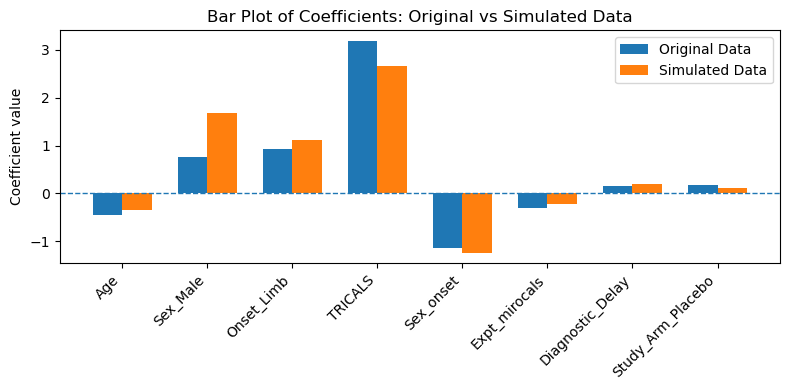

In [89]:
x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["Estimate_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["Estimate_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()


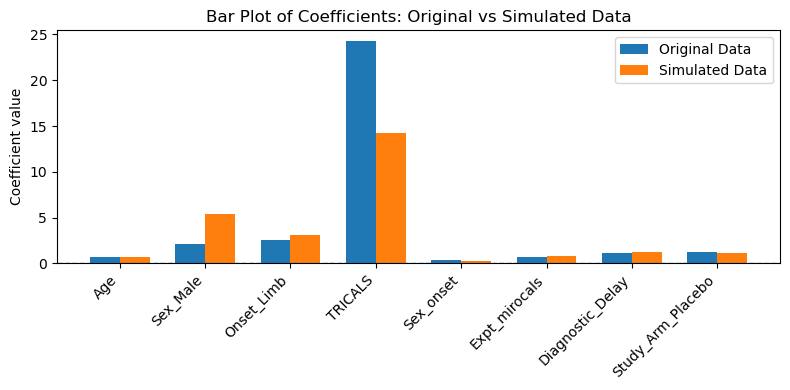

In [90]:
coefs1 = coefs[['Variable', 'HR_real', 'HR_simulated']]
coefs1

x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["HR_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["HR_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()

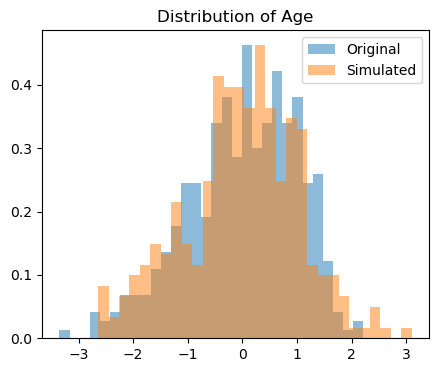

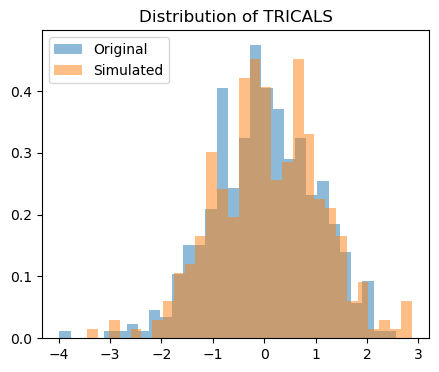

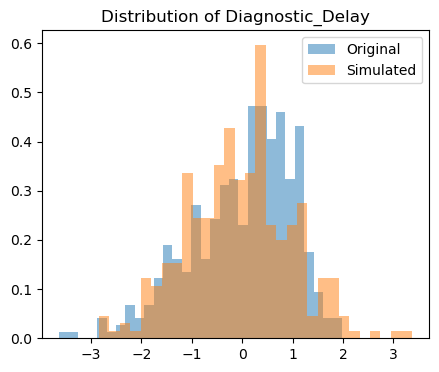

In [91]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(df1[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_df[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

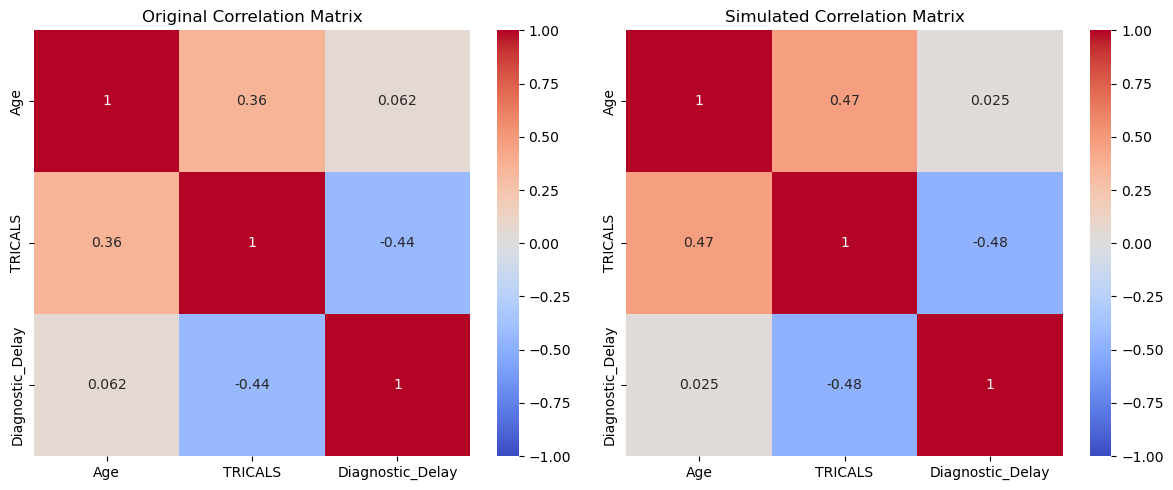

In [92]:
cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(df1[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()

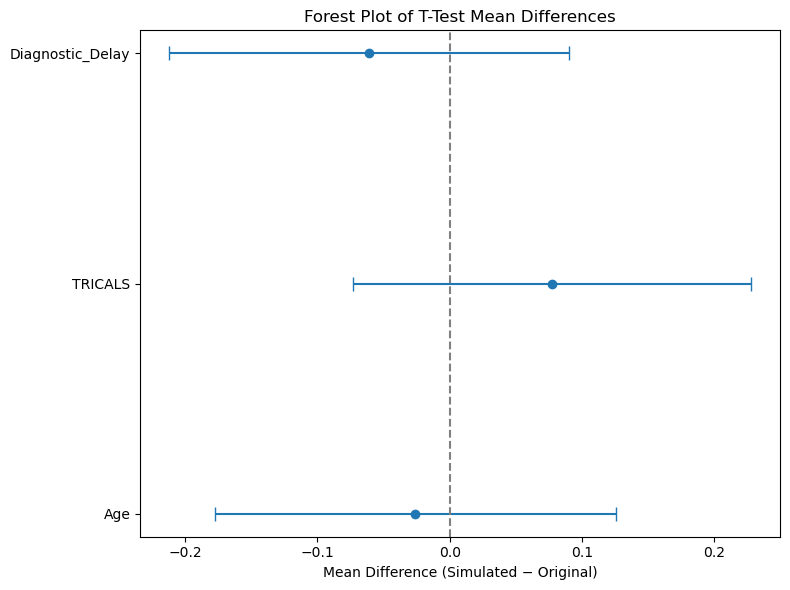

In [93]:
from scipy.stats import ttest_ind

cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

results = []

for col in cols:
    original = df1[col].dropna()
    simulated = sim_df[col].dropna()

    # Welch t-test
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)

    # Mean difference
    mean_diff = simulated.mean() - original.mean()

    # Standard errors for CI (Welch)
    se = np.sqrt(original.var()/len(original) + simulated.var()/len(simulated))

    # 95% CI
    ci_low = mean_diff - 1.96 * se
    ci_high = mean_diff + 1.96 * se

    results.append([col, mean_diff, ci_low, ci_high, p_val])

df_plot = pd.DataFrame(results, columns=["Variable", "MeanDiff", "CI_low", "CI_high", "p_value"])


# --------- Forest Plot ---------
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    df_plot["MeanDiff"], 
    y_pos, 
    xerr=[df_plot["MeanDiff"] - df_plot["CI_low"], df_plot["CI_high"] - df_plot["MeanDiff"]],
    fmt='o', 
    capsize=5
)

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Mean Difference (Simulated − Original)")
plt.title("Forest Plot of T-Test Mean Differences")

plt.tight_layout()
plt.show()

In [ ]:
# remove the interaction term from the model